# Assignment 3

### Question 1
#### Design and implement a CNN to be used in a task of Fingers Count classification. Given an image of a hand, your classifier should return the number represented (between 0 and 5). For example, the classification of the example image given below should be "3". The main aim is to maximize the classification accuracy. You should use and download the dataset from Kaggle. Your implementation should include the following:
- **Data pre-processing:** as per the provided dataset, the images are not already categorized into folders, and are just named according to the given class. Your data pre-processing implementation should take care of categorizing the data points and creating data loaders with the correct classes. This should be done internally in your implementation, and not manually beforehand (we should be able to reproduce your results by running the code on the original dataset from Kaggle). The dataset provided comes with train/test folders. You should keep the folders as is and use the given split. You can use the test folder for validation. As per your design, you should choose appropriate pre-processing techniques to be applied to the images.
- **Architecture design:** you should design your own CNN architecture with choices of number of layers, activation functions, kernel specifications, etc. You could try several architectures, but only report your final design.
- **Training and optimization:** the student has the freedom of choosing hyperparameter values (learning rate, number of epochs, loss function, etc), with the aim of maximizing the accuracy. Here, hyperparameter optimization/search is encouraged to find the best set of hyperparameters.
#### You should report on the designed architecture and the chosen hyperparameters. You should also report results by plotting training and validation accuracy vs batch/epoch. Finally, you should report classification scores (accuracy, recall, confusion matrix, etc) on the test set.

In [25]:
import os
import re
import pandas
import numpy
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import classification_report

device = "cuda:0"


- Label the images

In [ ]:
def create_annotations_file(_split_name):
    # Use the os module to extract labels from file names
    file_names = os.listdir(f"Data\\{_split_name}")

    label_rgx = r"[0-9][LR]"

    file_dataset_content = []

    for i in range(len(file_names)):
        label_match = re.search(label_rgx, file_names[i])
        file_dataset_content.append([file_names[i], int(label_match.__getitem__(0)[0])])

    # Create a CSV of labels ({file_name.ext},{label_int})
    file_dataframe = pandas.DataFrame(file_dataset_content, columns=["file_name", "label"])
    file_dataframe.to_csv(f"Data\\{_split_name}_annotations.csv", index=False)
    

In [16]:
create_annotations_file("train")

create_annotations_file("test")


- Create custom dataloader

In [45]:
import torch.utils
import torch.utils.data

class NumbersImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pandas.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(torch.float32)
        zero = torch.zeros(1, 128, 128)
        image = torch.cat((image, zero, zero), 0)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


- Define transforms for pre-processing

In [51]:
import torch.utils.data

preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
])

train_dataset = NumbersImageDataset("Data\\train_annotations.csv", "Data\\train", preprocessing)

train_size = int(0.8 * len(train_dataset))  
test_size = len(train_dataset) - train_size  
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

test_dataset = NumbersImageDataset("Data\\test_annotations.csv", "Data\\test", preprocessing)


- Architecture candidates

In [52]:
img_num_kernel_1 = 32

img_kernel_stride = 1

img_kernel_padding = 1

img_num_kernel_2 = 64

img_pool_size = 2

img_pool_stride = 2

img_kernel_size = 3

img_conv_neural_net = torch.nn.Sequential(
    torch.nn.Conv2d(3, img_num_kernel_1, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
    torch.nn.BatchNorm2d(img_num_kernel_1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(img_pool_size, stride=img_pool_stride),
    torch.nn.Conv2d(img_num_kernel_1, img_num_kernel_2, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
    torch.nn.BatchNorm2d(img_num_kernel_2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(img_pool_size, stride=img_pool_stride),
    torch.nn.Flatten(),
    torch.nn.Linear(img_num_kernel_2 * 56 * 56, 6)
)
img_conv_neural_net.to(device=device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=200704, out_features=6, bias=True)
)

- Hyperparameter searching + training loop

In [59]:
def plot_model_result(_losses, _accuracies, _val_losses, _val_accuracies, _batch_size = 32):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(numpy.arange(1, len(_losses) + 1), _losses, label="Train")
    momentum_loss_ax.plot(numpy.arange(1, len(_val_losses) + 1), _val_losses, label="Validation")
    momentum_loss_ax.set_xlabel(f"Epoch (Batch size = {_batch_size})")
    momentum_loss_ax.set_xticks(numpy.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"Epoch vs. Loss for Finger Numbers Set")
    momentum_loss_ax.legend()
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(numpy.arange(1, len(_accuracies) + 1), _accuracies, label="Train")
    momentum_acc_ax.plot(numpy.arange(1, len(_val_accuracies) + 1), _val_accuracies, label="Validation")
    momentum_acc_ax.set_xlabel(f"Epoch (Batch size = {_batch_size})")
    momentum_acc_ax.set_xticks(numpy.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(numpy.arange(0, 110, 10))
    momentum_acc_ax.set_title(f"Epoch vs. Accuracy for Finger Numbers Set")
    momentum_acc_ax.legend()
    momentum_acc_ax.grid()

    plt.show()


def do_train_loop(_train_dataset, _val_dataset, _num_epochs = 5, _num_sample = 3, _use_custom_model = False, _resnet_weights = None):
    best_loss = -1.0

    best_accuracy = -1.0

    best_config = (0, 0.0)

    best_model = None

    loss_fn = torch.nn.CrossEntropyLoss()

    for i in range(_num_sample):
        batch_size = numpy.random.randint(8, 32)

        learning_rate = numpy.random.choice([0.1, 0.01, 0.001, 0.0001])

        model = None

        if _use_custom_model:
            model = torch.nn.Sequential(
                torch.nn.Conv2d(3, img_num_kernel_1, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
                torch.nn.BatchNorm2d(img_num_kernel_1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(img_pool_size, stride=img_pool_stride),
                torch.nn.Conv2d(img_num_kernel_1, img_num_kernel_2, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
                torch.nn.BatchNorm2d(img_num_kernel_2),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(img_pool_size, stride=img_pool_stride),
                torch.nn.Flatten(),
                torch.nn.Linear(img_num_kernel_2 * 56 * 56, 6)
            )
        elif _resnet_weights != None:
            model = resnet18(weights=_resnet_weights)
            num_features = model.fc.in_features
            model.fc = torch.nn.Linear(num_features, 6)
        else:
            model = resnet18(weights=_resnet_weights, num_classes=6)
        
        model.to(device=device)

        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        train_dataloader = torch.utils.data.DataLoader(_train_dataset, batch_size, True)
        
        val_dataloader = torch.utils.data.DataLoader(_val_dataset, batch_size, True)
        
        num_train_minibatch = len(train_dataloader)
        
        num_val_minibatch = len(val_dataloader)

        train_epoch_losses = []
        
        val_epoch_losses = []
        
        train_epoch_acc = []
        
        val_epoch_acc = []
        
        print(f"Beginning new sample: batch size = {batch_size}, learning rate = {learning_rate}...\n")

        for epoch in range(_num_epochs):
            total_train_loss = 0.0

            total_train_accuracy = 0.0
            
            model.train()

            for data, label in train_dataloader:
                data, label = data.to(device), label.to(device)

                optimizer.zero_grad()

                train_logits = model(data)
                train_loss = loss_fn(train_logits, label)
                train_loss.backward()

                optimizer.step()

                total_train_loss += train_loss.item()

                total_train_accuracy += ((torch.argmax(torch.softmax(train_logits, dim=1), dim=1) == label).sum().item() / len(label)) * 100

            train_epoch_losses.append(total_train_loss / num_train_minibatch)   
            
            train_epoch_acc.append(total_train_accuracy / num_train_minibatch)

            total_val_loss = 0.0

            total_val_accuracy = 0.0
            
            model.eval()

            for data, label in val_dataloader:
                data, label = data.to(device), label.to(device)

                val_logits = model(data)
                val_loss = loss_fn(val_logits, label)
                total_val_loss += val_loss.item()

                total_val_accuracy += ((torch.argmax(torch.softmax(val_logits, dim=1), dim=1) == label).sum().item() / len(label)) * 100

            val_epoch_losses.append(total_val_loss / num_val_minibatch)   
            
            val_epoch_acc.append(total_val_accuracy / num_val_minibatch)
            
            print(f"[Epoch {epoch + 1}] train average loss = {train_epoch_losses[-1]:.4f} -- val average loss = {val_epoch_losses[-1]:.4f}, train average accuracy = {train_epoch_acc[-1]:.2f}% -- val average accuracy = {val_epoch_acc[-1]:.2f}%")

            if (val_epoch_losses[epoch] >= val_epoch_losses[epoch - 1] or val_epoch_losses[epoch] < 0.009) and len(val_epoch_losses) > 1:
                break

        print("\nFinished sample test, moving on to next one...\n")

        if best_loss < 0.0 or val_epoch_losses[-1] < best_loss:
            best_loss = val_epoch_losses[-1]

            best_accuracy = val_epoch_acc[-1]

            best_config = (batch_size, learning_rate)

            best_model = model

        plot_model_result(train_epoch_losses, train_epoch_acc, val_epoch_losses, val_epoch_acc, _batch_size=batch_size)

    print(f"Best config found: batch size = {best_config[0]}, learning rate = {best_config[1]}\nConfig loss = {best_loss:.4f}, config accuracy = {best_accuracy:.2f}%")

    return best_config, best_model

Beginning new sample: batch size = 9, learning rate = 0.001...

[Epoch 1] train average loss = 0.9746 -- val average loss = 0.1893, train average accuracy = 97.11% -- val average accuracy = 99.61%
[Epoch 2] train average loss = 0.1506 -- val average loss = 0.7864, train average accuracy = 99.60% -- val average accuracy = 98.22%

Finished sample test, moving on to next one...



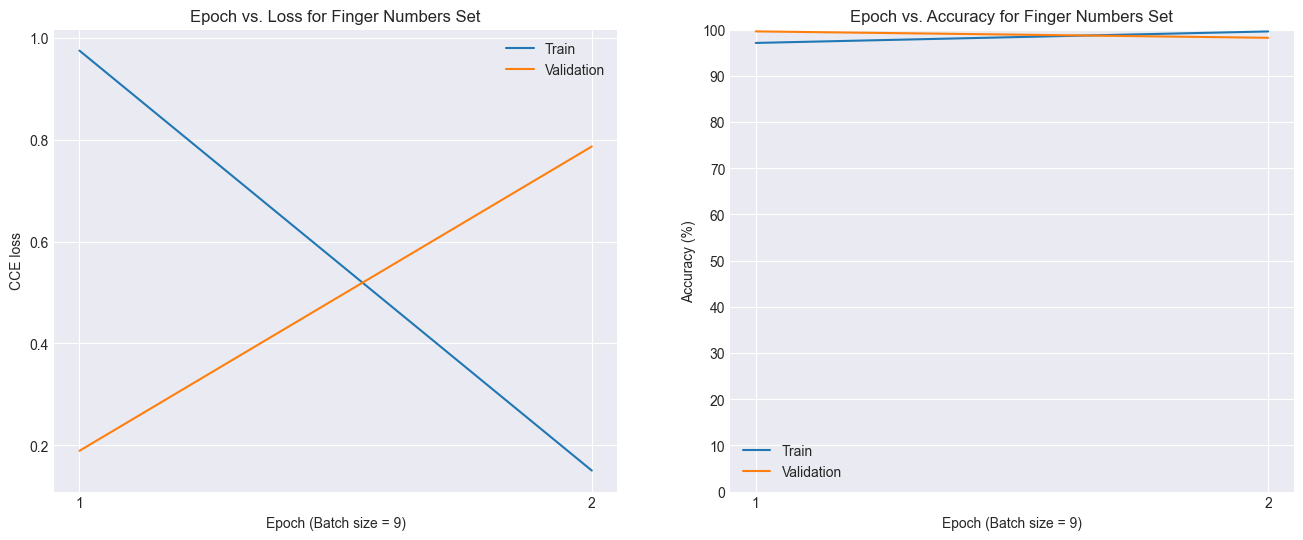

Beginning new sample: batch size = 11, learning rate = 0.001...

[Epoch 1] train average loss = 1.0593 -- val average loss = 0.1716, train average accuracy = 97.00% -- val average accuracy = 99.47%
[Epoch 2] train average loss = 0.2009 -- val average loss = 0.0000, train average accuracy = 99.35% -- val average accuracy = 100.00%

Finished sample test, moving on to next one...



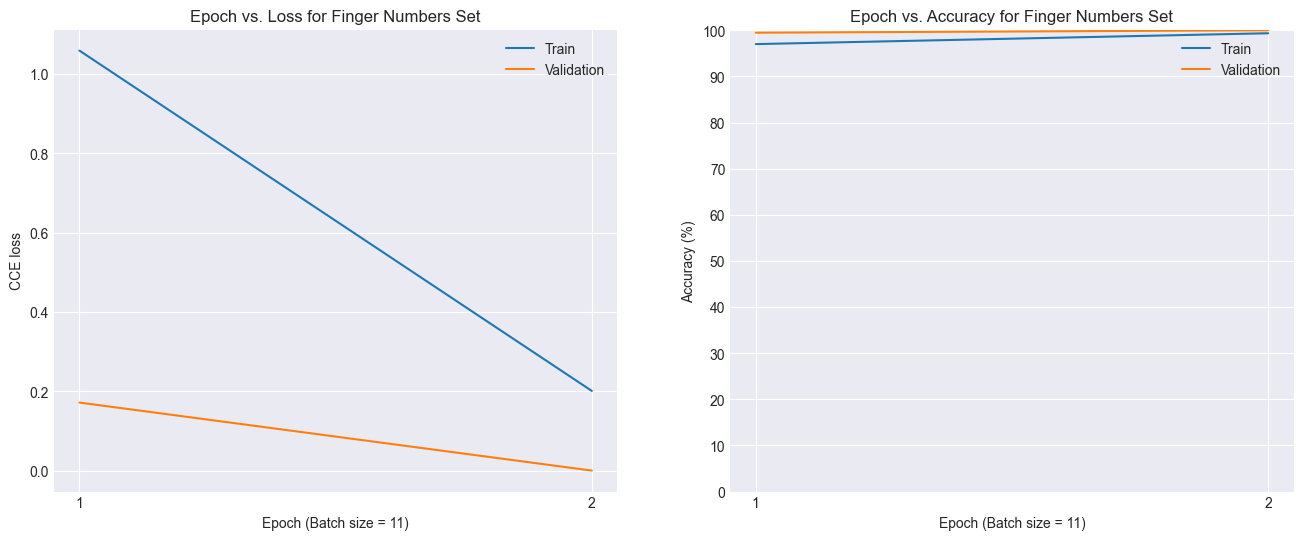

Beginning new sample: batch size = 23, learning rate = 0.1...

[Epoch 1] train average loss = 31.1710 -- val average loss = 0.0076, train average accuracy = 95.96% -- val average accuracy = 99.78%
[Epoch 2] train average loss = 0.0074 -- val average loss = 0.0041, train average accuracy = 99.76% -- val average accuracy = 99.92%

Finished sample test, moving on to next one...



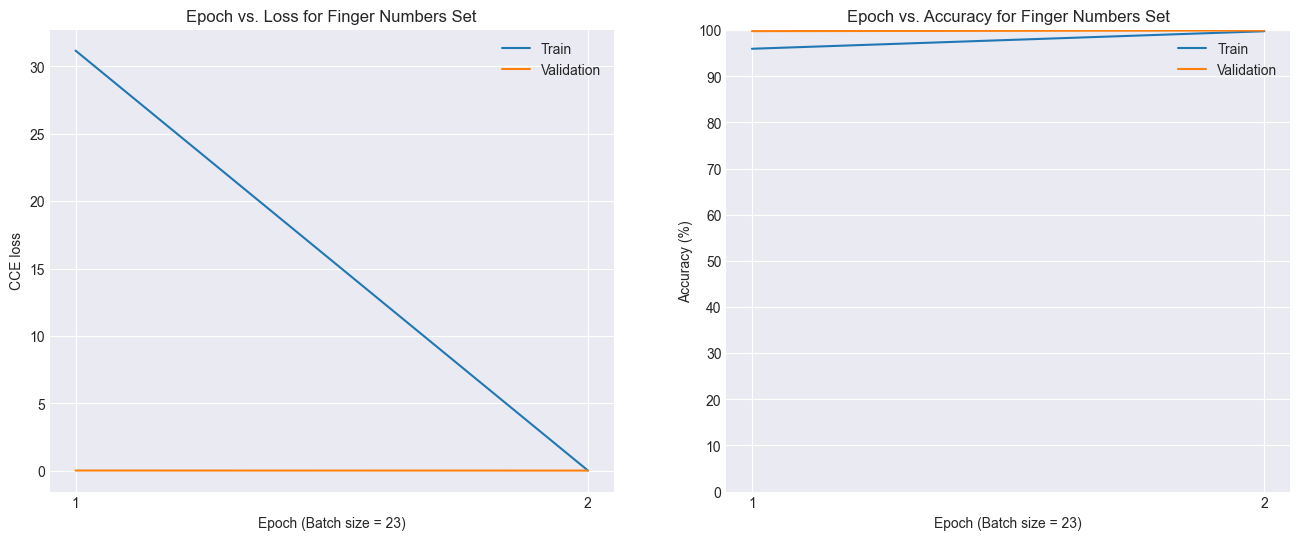

Best config found: batch size = 11, learning rate = 0.001
Config loss = 0.0000, config accuracy = 100.00%


In [21]:
config, model = do_train_loop(train_dataset, val_dataset, _use_custom_model=True)


- Classification Report

In [55]:
def do_classification_report(test_dataset, config, model):
    test_dataloader = torch.utils.data.DataLoader(test_dataset, config[0], True)

    test_pred = None

    test_labels = None

    model.eval()

    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        output = torch.argmax(torch.softmax(model(data), dim=1), dim=1)
        test_pred = output if test_pred == None else torch.hstack((test_pred, output))
        
        test_labels = label if test_labels == None else torch.hstack((test_labels, label))

    print(classification_report(test_pred.cpu().numpy(), test_labels.cpu().numpy()))

In [24]:
do_classification_report(test_dataset, config, model)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       599
           2       1.00      1.00      1.00       602
           3       1.00      1.00      1.00       599
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



- Seeing as the data was relatively simple and was normalized via batch normalization, each sample had fast convergence and good scores. 

### Question 2
#### Replace your designed architecture in the previous question with the predefined ResNet18 architecture in PyTorch, to be trained from scratch. While maintaining the same hyperparameters and data pre-processing techniques (aside from resizing), compare the performance of the two architectures by plotting training/validation accuracy and reporting on the testing results. (note: you cannot change the structure of any of the Conv layers in ResNet18. You can only change the last FC layer to match the number of outputs needed.).

- Training

Beginning new sample: batch size = 27, learning rate = 0.01...

[Epoch 1] train average loss = 0.2250 -- val average loss = 0.0002, train average accuracy = 92.09% -- val average accuracy = 100.00%
[Epoch 2] train average loss = 0.0069 -- val average loss = 0.0160, train average accuracy = 99.81% -- val average accuracy = 99.59%

Finished sample test, moving on to next one...



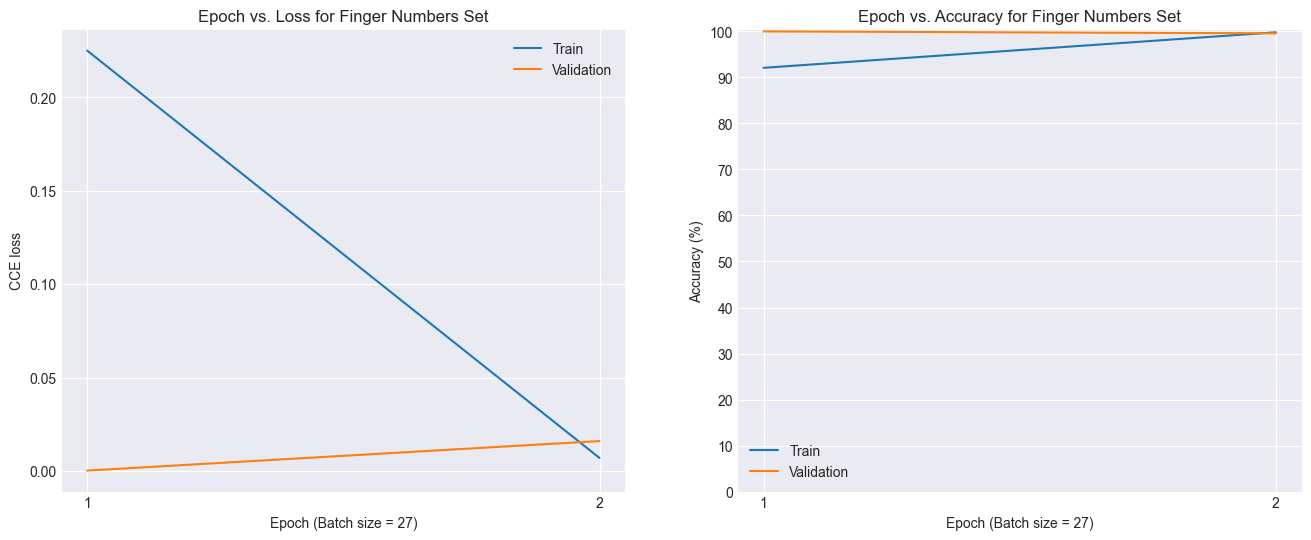

Beginning new sample: batch size = 13, learning rate = 0.1...

[Epoch 1] train average loss = 0.4773 -- val average loss = 0.8861, train average accuracy = 84.59% -- val average accuracy = 75.94%
[Epoch 2] train average loss = 0.0515 -- val average loss = 0.0070, train average accuracy = 98.44% -- val average accuracy = 99.69%

Finished sample test, moving on to next one...



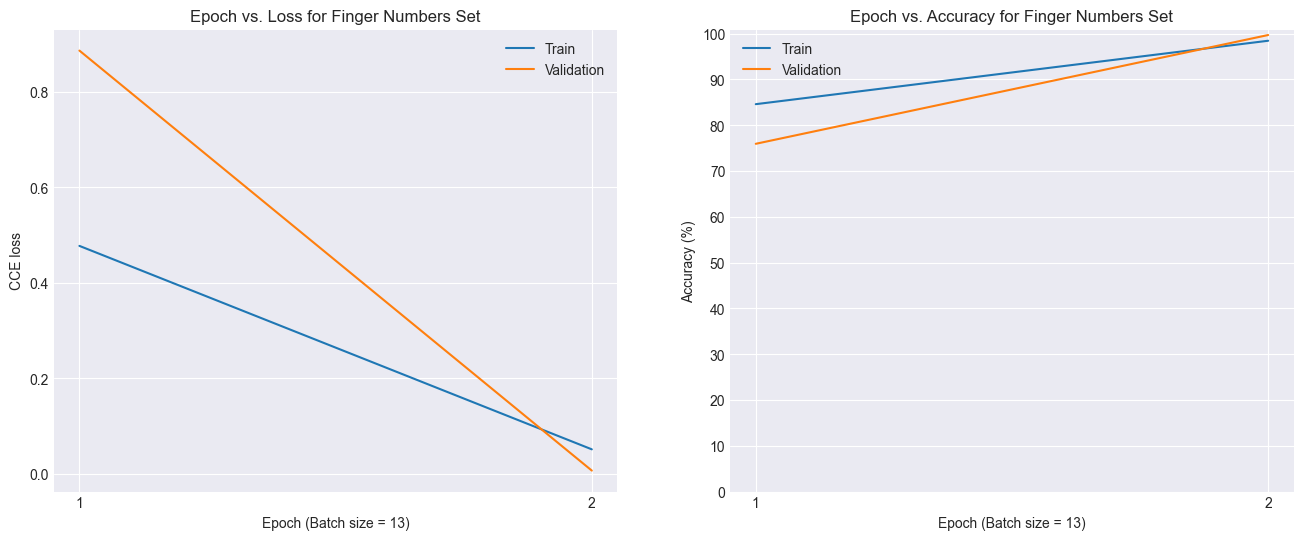

Beginning new sample: batch size = 12, learning rate = 0.01...

[Epoch 1] train average loss = 0.1906 -- val average loss = 0.0554, train average accuracy = 93.01% -- val average accuracy = 98.31%
[Epoch 2] train average loss = 0.0448 -- val average loss = 0.0035, train average accuracy = 98.67% -- val average accuracy = 99.92%

Finished sample test, moving on to next one...



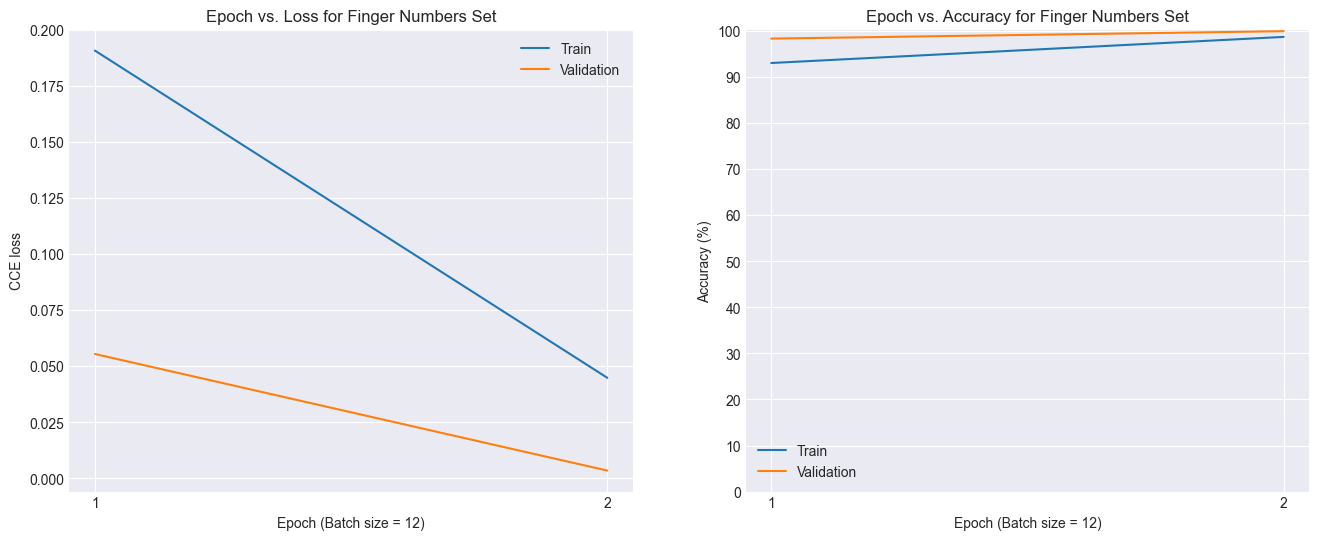

Best config found: batch size = 12, learning rate = 0.01
Config loss = 0.0035, config accuracy = 99.92%


In [54]:
renset_config, resnet_model = do_train_loop(train_dataset, val_dataset)


- Test classification report

In [56]:
do_classification_report(test_dataset, renset_config, resnet_model)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       0.99      1.00      1.00       595
           2       1.00      0.99      1.00       605
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



- Similarly, a fresh ResNet model achieves comparable scores due to the underlying architecture providing good initializations and remedies to vanishing gradients.

### Question 3
#### Repeat the process in the previous question by using the pre-defined ResNet18 with transfer learning, by loading the "ResNet18_Weights.IMAGENET1K_V1". Report on the training, validation, and testing results.

- Training

Beginning new sample: batch size = 19, learning rate = 0.0001...

[Epoch 1] train average loss = 0.0224 -- val average loss = 0.0001, train average accuracy = 99.52% -- val average accuracy = 100.00%
[Epoch 2] train average loss = 0.0056 -- val average loss = 0.0000, train average accuracy = 99.83% -- val average accuracy = 100.00%

Finished sample test, moving on to next one...



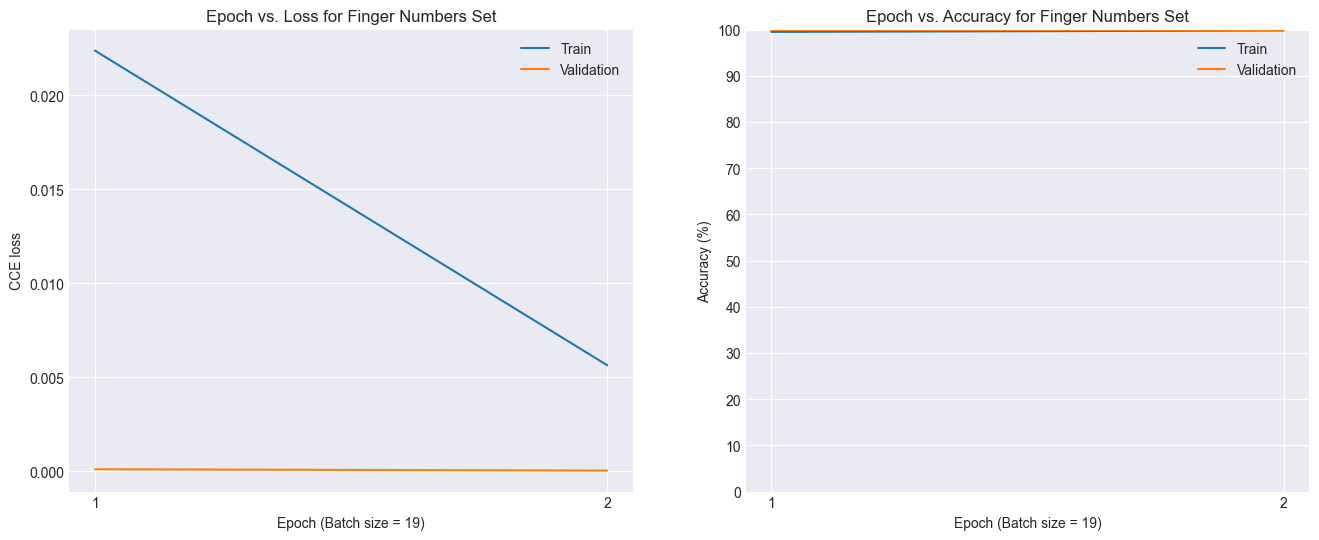

Beginning new sample: batch size = 17, learning rate = 0.001...

[Epoch 1] train average loss = 0.0435 -- val average loss = 0.0000, train average accuracy = 98.49% -- val average accuracy = 100.00%
[Epoch 2] train average loss = 0.0100 -- val average loss = 0.0000, train average accuracy = 99.76% -- val average accuracy = 100.00%

Finished sample test, moving on to next one...



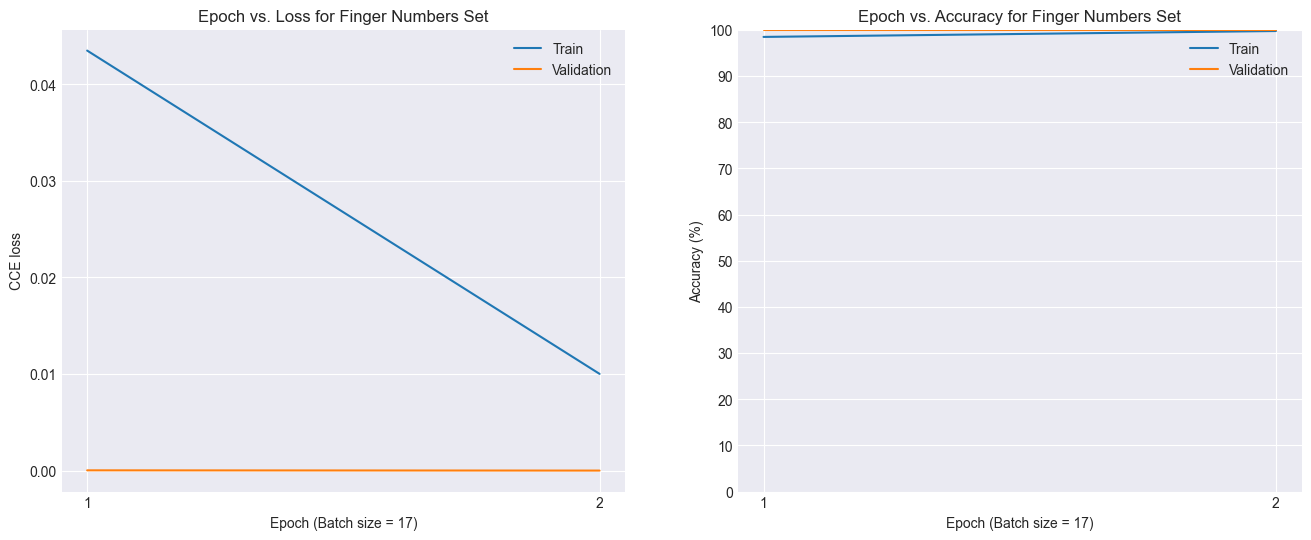

Beginning new sample: batch size = 25, learning rate = 0.001...

[Epoch 1] train average loss = 0.0272 -- val average loss = 0.0004, train average accuracy = 99.15% -- val average accuracy = 100.00%
[Epoch 2] train average loss = 0.0147 -- val average loss = 0.0010, train average accuracy = 99.52% -- val average accuracy = 99.97%

Finished sample test, moving on to next one...



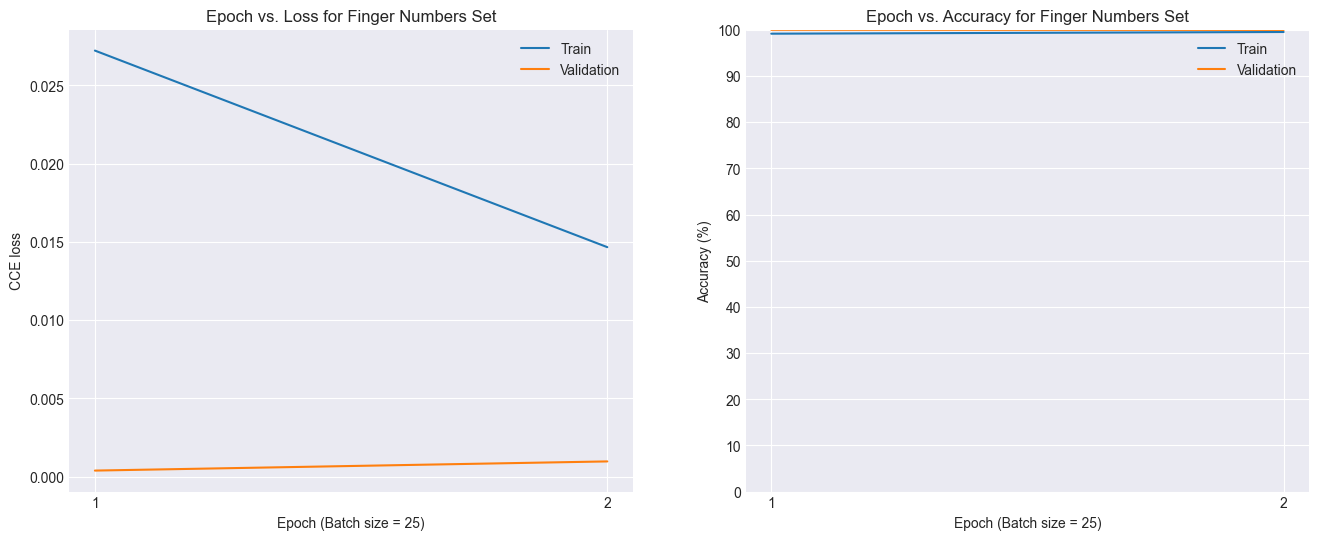

Best config found: batch size = 17, learning rate = 0.001
Config loss = 0.0000, config accuracy = 100.00%


In [60]:
imagenet_config, imagenet_model = do_train_loop(train_dataset, val_dataset, _resnet_weights=ResNet18_Weights.IMAGENET1K_V1)


- Test classification report

In [61]:
do_classification_report(test_dataset, imagenet_config, imagenet_model)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



- Finally, the ImageNet pre-trianed model predictably got very high scores as it leverages everything that came before and has already pre-trained its encoder to extract good features from the images.

### Question 4

#### Build an LSTM-based model for time-series forecasting using PyTorch. Given a series of data points, the model should be able to predict the next data point. You should use the Daily Climate Time Series dataset for this task. We will only use the "meantemp" column, where the aim is to use the temperatures from the previous days to predict the next temperature value.

In [1]:
import math
import numpy
import pandas
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler


#### a) We will only use the "meantemp" column to train our model, hence you should remove the remaining columns from the dataset. Additionally, since our prediction is based on the historical trend, each data point (each row) in the dataset should be in the form of sequence -> prediction. Assume we want to use a sequence window of size 10 in this problem. Preprocess the dataset such that each sequence of 10 values is used to predict the 11th value. You can refer to this article for some examples on how to preprocess the data into sequences. (hint: if your original dataset has 100 data points, then the preprocessed dataset would have 100-10=90 data points/sequences).

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        X.append(feature)
        
        target = dataset[i+1:i+lookback+1]
        y.append(target)
        
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


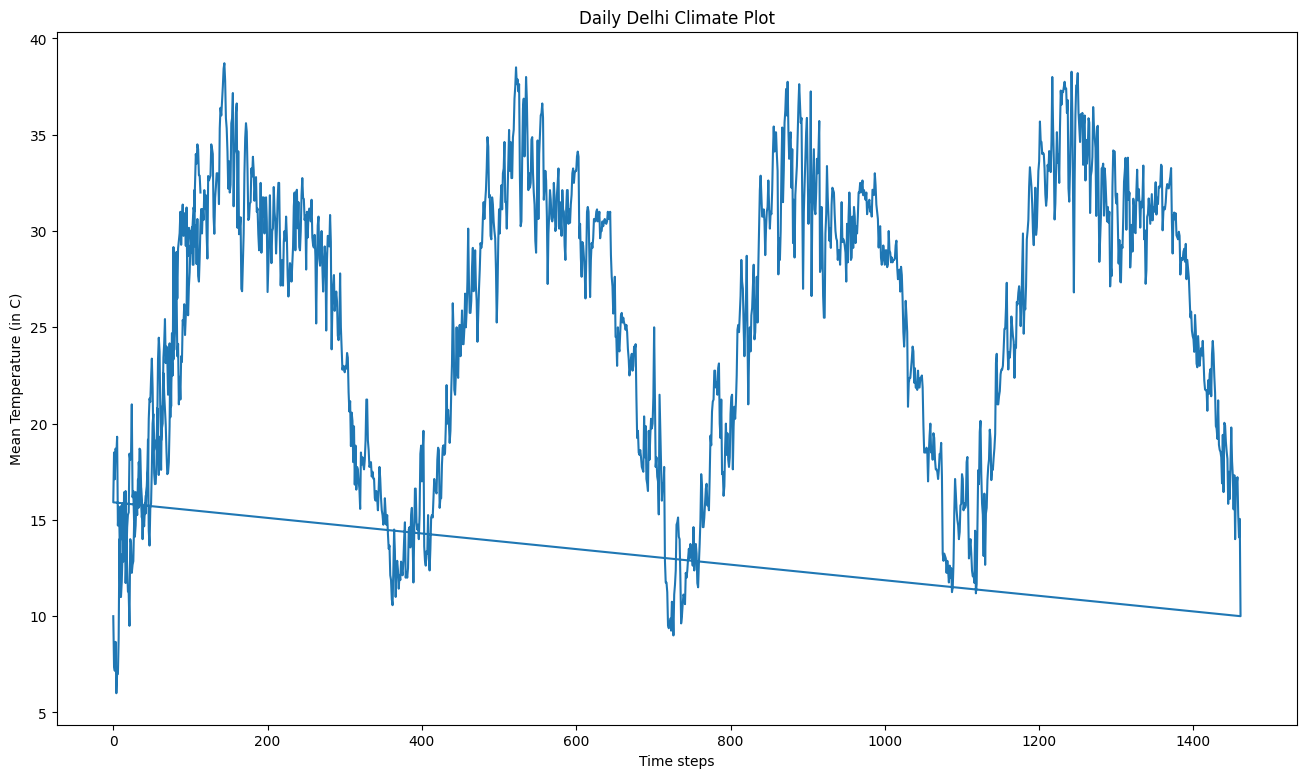

In [8]:
climate_train_series = pandas.read_csv("DailyDelhiClimateTrain.csv").meantemp
climate_test_series = pandas.read_csv("DailyDelhiClimateTest.csv").meantemp
climate_full_series = pandas.concat([climate_train_series, climate_test_series], axis=0)
plt.figure(figsize=(16,9))
plt.plot(climate_full_series)
plt.xlabel("Time steps")
plt.ylabel("Mean Temperature (in C)")
plt.title("Daily Delhi Climate Plot")
plt.show()

look_back_window = 10

'''
https://stackoverflow.com/questions/61565156/why-pandas-core-series-series-sometimes-cannot-convert-to-torch-tensor-in-python
Had to convert series into numpy first due to pytorch expecting 0 index to exist per slice 
'''
train_data, train_target = create_dataset(climate_full_series.to_numpy(), look_back_window)


#### b) Preprocess the data using the MinMaxScaler from scikit-learn. There is no need to split or shuffle the data for this question.

In [10]:
scaler = MinMaxScaler()
train_data = torch.tensor(scaler.fit_transform(train_data, train_target), dtype=torch.float32)


#### c) Train a vanilla LSTM to forecast the mean temperature based on the last 10 values. You can refer to this article for some guidance. You are free to choose and optimize the hyperparameters (optimizer, batch size, etc), but you should use the MSE loss. Aim for better performance.

In [11]:
class DelhiClimateModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=10, hidden_size=50, num_layers=1, batch_first=True, dtype=torch.float32)
        self.linear = torch.nn.Linear(50, 10, dtype=torch.float32)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    

In [12]:
device = "cuda:0"

stock_model = DelhiClimateModel()
stock_model.to(device)

optimizer = torch.optim.Adam(stock_model.parameters())

loss_fn = torch.nn.MSELoss()

batch_size = 8

num_epochs = 100

num_minibatches = math.ceil(len(train_data) / batch_size)

training_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for i in range(0, train_data.shape[0], batch_size):
        X = train_data[i:i+batch_size].to(device)
        y = train_target[i:i+batch_size].to(device)

        optimizer.zero_grad()

        output = stock_model(X)
        loss = loss_fn(output, y).to(torch.float32)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    training_losses.append(total_loss / num_minibatches)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss (MSE) = {training_losses[epoch]}")


Epoch 0: loss (MSE) = 466.6150047925054
Epoch 10: loss (MSE) = 7.899184223340482
Epoch 20: loss (MSE) = 4.174129081928
Epoch 30: loss (MSE) = 3.4555845499342803
Epoch 40: loss (MSE) = 2.9744806041066743
Epoch 50: loss (MSE) = 2.7746782942998167
Epoch 60: loss (MSE) = 2.173071224318475
Epoch 70: loss (MSE) = 1.736046830382274
Epoch 80: loss (MSE) = 1.5322407307673473
Epoch 90: loss (MSE) = 1.3417986074500545


#### d) Analyze the performance of your model by plotting the training loss. Using the available data, compare the original plot of the data points with the predicted plot (each data point on the predicted plot is obtained by feeding the previous 10 data points from the original data).

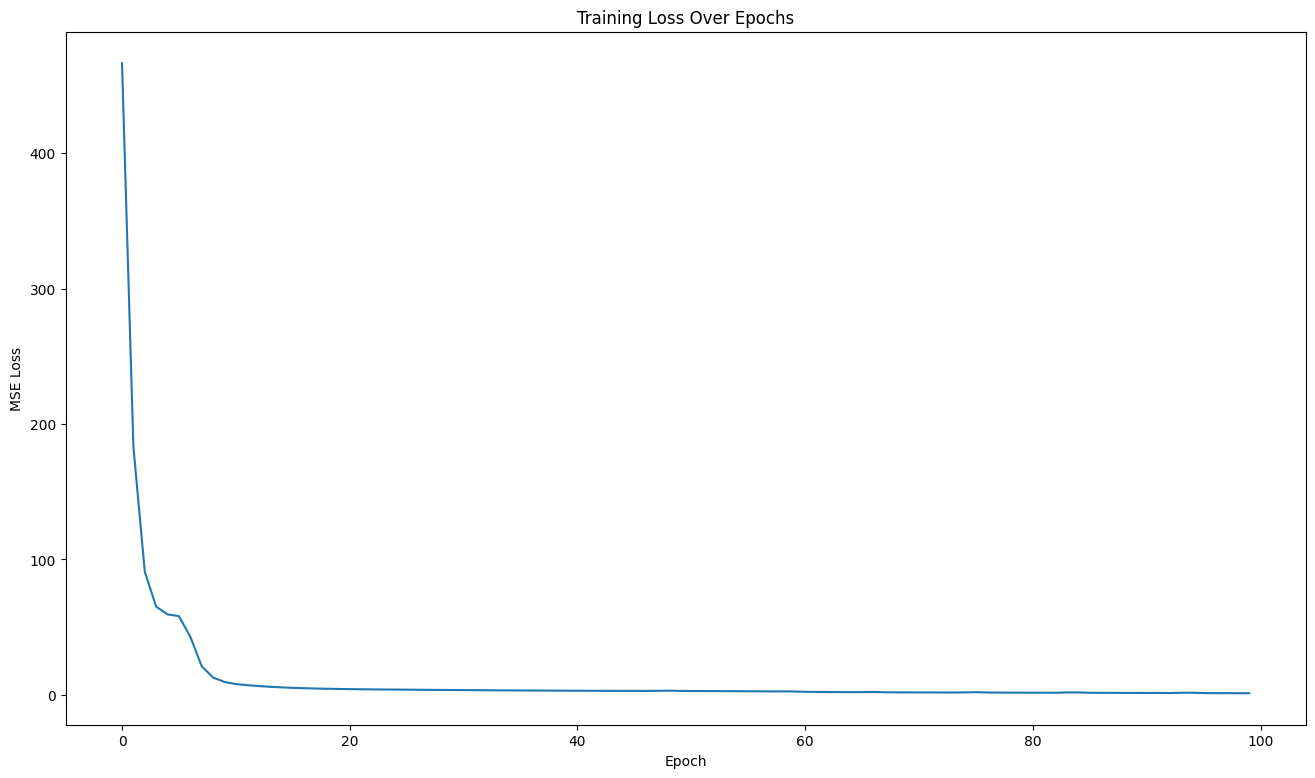

In [13]:
plt.figure(figsize=(16,9))
plt.plot(numpy.arange(0, len(training_losses)), training_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.show()


- Given the fact that the data in this problem must be sequencial and so shouldn't be split or shuffled, the model has a much easier time getting good training results.

In [19]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = numpy.ones_like(climate_full_series) * numpy.nan
    train_plot = stock_model(train_data.to(device))[:, -1].cpu().numpy()


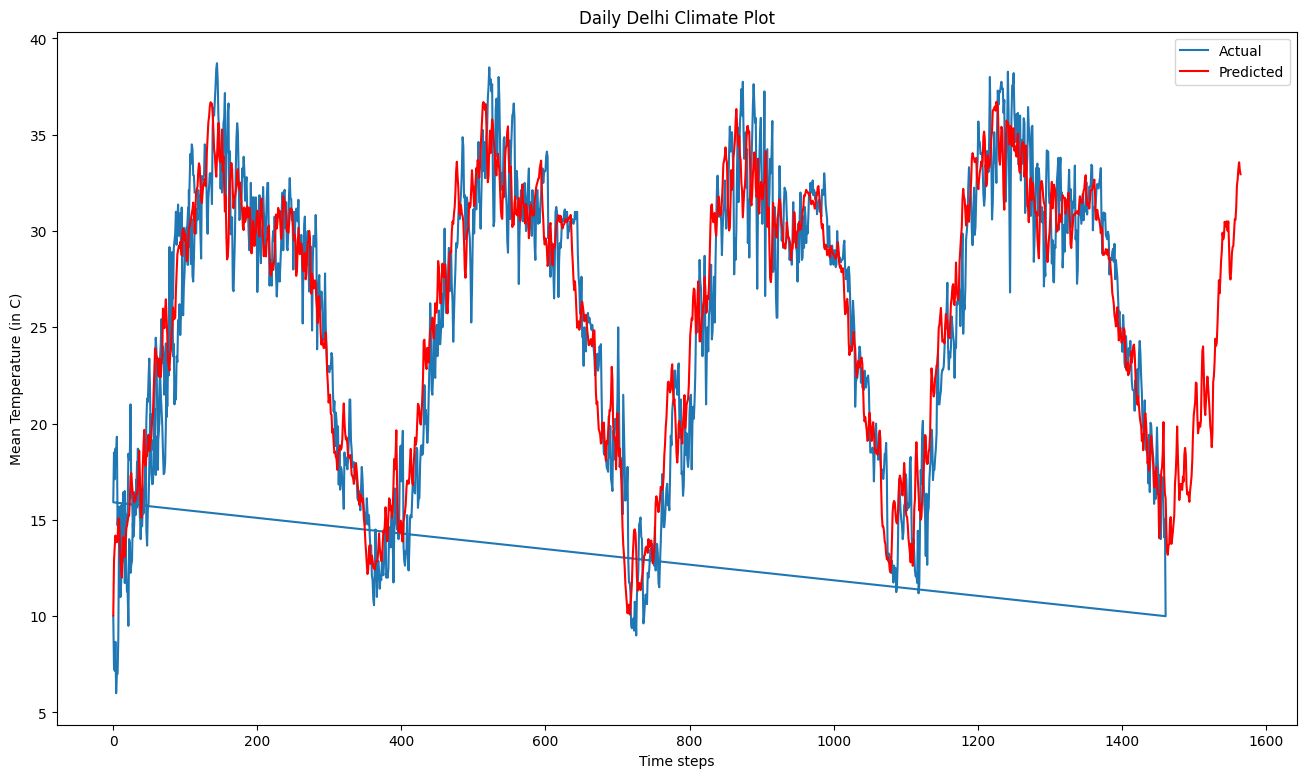

In [22]:
plt.figure(figsize=(16,9))
plt.plot(climate_full_series, label="Actual")
plt.plot(train_plot, c='r', label="Predicted")
plt.xlabel("Time steps")
plt.ylabel("Mean Temperature (in C)")
plt.title("Daily Delhi Climate Plot")
plt.legend()
plt.show()
